In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
import tensorflow as tf
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import plot_model
from sklearn.preprocessing import MinMaxScaler

In [2]:
df = yf.download (tickers=['AAPL'], period='1y')
y = df['Close'].fillna (method='ffill')
y = y.values.reshape(-1, 1)

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['AAPL']: YFRateLimitError('Too Many Requests. Rate limited. Try after a while.')
<ipython-input-2-56dd78224188>:2: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  y = df['Close'].fillna (method='ffill')


In [11]:
scaler = MinMaxScaler(feature_range=(0, 1))
y_scaled = scaler.fit_transform(y)

ValueError: Found array with 0 sample(s) (shape=(0, 1)) while a minimum of 1 is required by MinMaxScaler.

In [6]:
n_lookback = 60 # jumlah data input (lookback period)
n_forecast = 60 # jumlah data output (forecast period)

X = []
Y = []

for i in range(n_lookback, len(y) - n_forecast + 1):
    X.append(y[i - n_lookback:i])
    Y.append(y[i:i + n_forecast])

X = np.array(X)
Y = np.array(Y)

In [7]:
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(n_lookback, 1)))
model.add(LSTM(units=50))
model.add(Dense(n_forecast))

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [8]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 60, 50)         │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 60)             │         3,060 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 33,660 (131.48 KB)

 Trainable params: 33,660 (131.48 KB)

 Non-trainable params: 0 (0.00 B)

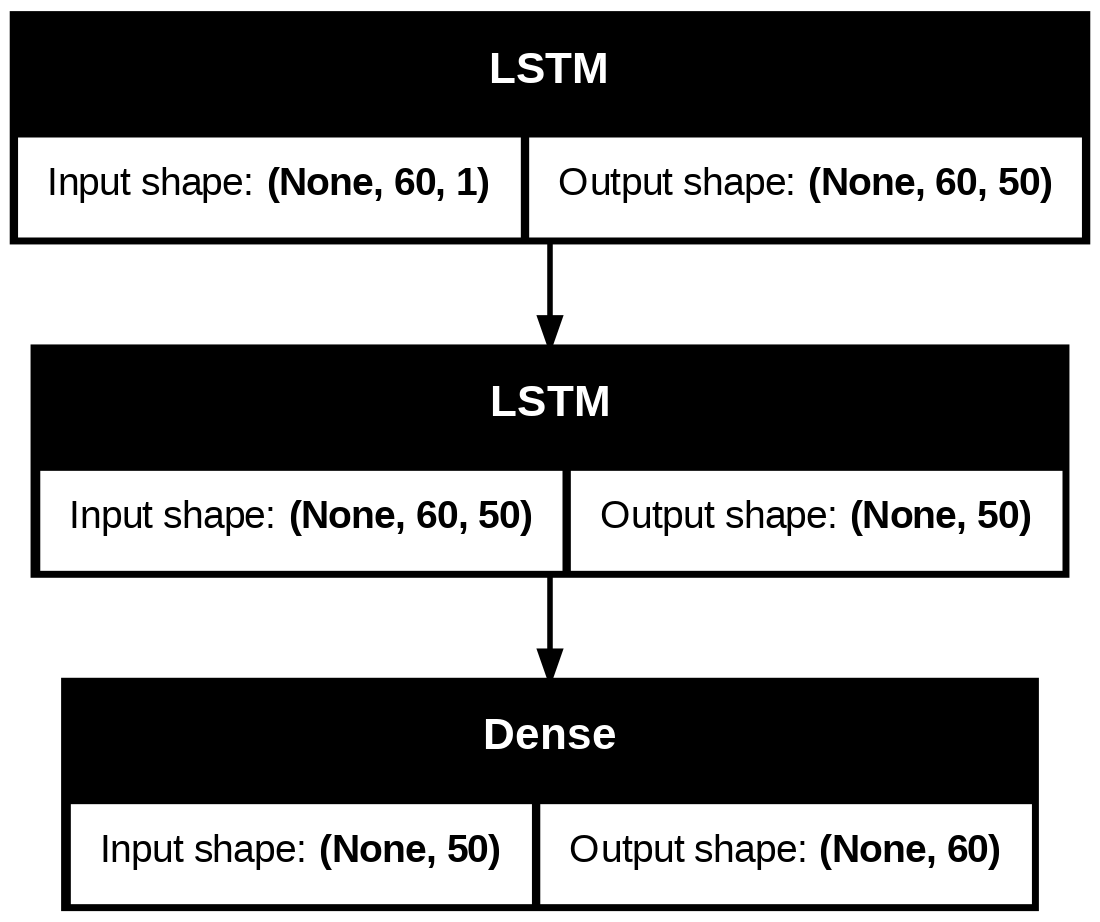

In [9]:
plot_model(model, show_shapes= True)

In [ ]:
model.compile(loss='mean_squared_error', optimizer='adam')

In [ ]:
model.fit(X, Y, epochs=100, batch_size=32, validation_split=0.1)

Epoch 1/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 6s 247ms/step - loss: 0.5472 - val_loss: 0.4313
Epoch 2/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 89ms/step - loss: 0.4953 - val_loss: 0.3713
Epoch 3/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - loss: 0.4300 - val_loss: 0.2739
Epoch 4/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - loss: 0.3119 - val_loss: 0.1908
Epoch 5/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 87ms/step - loss: 0.1926 - val_loss: 0.1514
Epoch 6/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 83ms/step - loss: 0.1317 - val_loss: 0.1002
Epoch 7/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - loss: 0.0781 - val_loss: 0.0668
Epoch 8/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - loss: 0.0443 - val_loss: 0.0517
Epoch 9/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - loss: 0.0274 - val_loss: 0.0449
Epoch 10/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step - loss: 0.0183 - val_loss: 0.0423
Epoch 11/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - loss: 0.0159 - val_loss: 0.0401
Epoch 12/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - loss: 0.0149 - val_l

In [ ]:
X_ = y[- n_lookback:] # urutan inputan terakhir
X_ = X_.reshape(1, n_lookback, 1)

Y_ = model.predict(X_)
Y_ = scaler.inverse_transform(Y_)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 411ms/step


In [ ]:
df_past = df [['Close']].reset_index()
df_past.rename(columns={'index': 'Date', 'Close': 'Actual'}, inplace=True)
df_past['Date'] = pd.to_datetime(df_past['Date'])
df_past['Forecast'] = np.nan
df_past['Forecast'].iloc[-1] = df_past['Actual'].iloc[-1]

<ipython-input-24-d69771c4f270>:5: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df_past['Forecast'].iloc[-1] = df_past['Actual'].iloc[-1]
<ipython-input-24-d69771c4f270>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a

In [ ]:
df_future = pd.DataFrame(columns=['Date', 'Actual', 'Forecast'])
df_future['Date'] = pd.date_range(start=df_past['Date'].iloc[-1] + pd.Timedelta(days=1), periods=n_forecast)
df_future['Forecast'] = Y_.flatten()
df_future['Actual'] = np.nan

In [ ]:
results = df_past._append(df_future).set_index('Date')

<Axes: title={'center': 'APPL'}, xlabel='Date'>

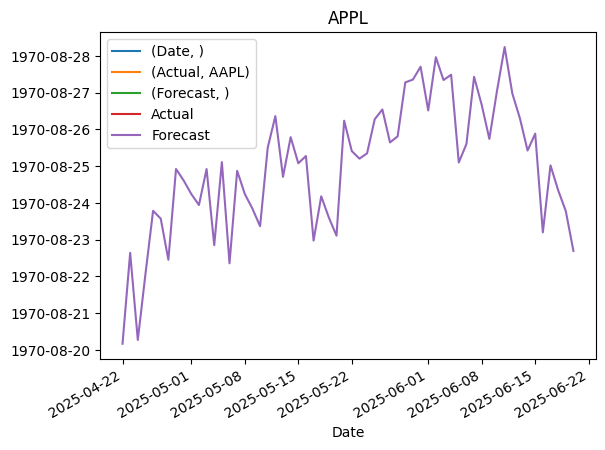

In [ ]:
results.plot(title='APPL')